In [6]:
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
conn = MavlinkConnection('tcp:127.0.0.1:5760', threaded=True)
drone = Drone(conn)
drone.start()

Logs\TLog.txt


In [7]:
import time
import math

drone.take_control()
drone.arm()

drone.set_home_position(drone.global_position[0], 
                        drone.global_position[1], 
                        drone.global_position[2])

drone.takeoff(3)

drone.cmd_position(5,0,3,0)
time.sleep(2)
drone.cmd_position(0,0,3, -math.pi)
time.sleep(2)
drone.cmd_position(0,0,3, 0)
time.sleep(2)
drone.land()
time.sleep(2)
drone.disarm()

In [1]:
import pandas as pd

drone_telemetry_log_df = pd.read_csv("drone_journey_log.txt", header=None)

local_position = drone_telemetry_log_df[drone_telemetry_log_df[0] == "MsgID.LOCAL_POSITION"]
# Convert NED to ENU coordinates. NED coordinates are in the order y, x, z
local_position.columns = ["msg_id", "time", "y", "x", "z"]
local_position = local_position.astype({"time": float, "x": float, "y": float, "z": float})
local_position['z'] = local_position['z'] * -1

local_velocity = drone_telemetry_log_df[drone_telemetry_log_df[0] == "MsgID.LOCAL_VELOCITY"]
local_velocity = drone_telemetry_log_df[drone_telemetry_log_df[1] != 0]
local_velocity.columns = ["msg_id", "time", "vx", "vy", "vz"]
local_velocity = local_velocity.astype({"time": float, "vx": float, "vy": float, "vz": float})

global_position = drone_telemetry_log_df[drone_telemetry_log_df[0] == "MsgID.GLOBAL_POSITION"]
global_position.columns = ["msg_id", "time", "lat", "lon", "alt"]
global_position = global_position.astype({"time": float, "lat": float, "lon": float, "alt": float})

# Define the planned trajectory take-off, waypoints (rectangle 10x10 with only corner points), and landing
planned_trajectory = pd.DataFrame({
    'x': [0, 0, 0,  10, 10, 0, 0],
    'y': [0, 0, 10, 10,  0, 0, 0],
    'z': [0, 3,  3,  3,  3, 3, 0]
})

# quivers
planned_trajectory_quivers = pd.DataFrame({
    'x': [0, 0, 0,  10, 10, 0, 0],
    'y': [0, 0, 10, 10,  0, 0, 0],
    'z': [0, 3,  3,  3,  3, 3, 0]
})

In [2]:
local_position

,msg_id,time,y,x,z
2,MsgID.LOCAL_POSITION,1081.121,0.029226,0.409838,-0.063472
8,MsgID.LOCAL_POSITION,1081.372,0.028153,0.375813,-0.069823
12,MsgID.LOCAL_POSITION,1081.622,0.171634,0.260443,-0.063128
16,MsgID.LOCAL_POSITION,1081.871,0.080022,0.313311,-0.043328
20,MsgID.LOCAL_POSITION,1082.122,0.025546,0.287069,-0.018346
...,...,...,...,...,...
344,MsgID.LOCAL_POSITION,1100.135,-0.170471,0.162644,0.140836
350,MsgID.LOCAL_POSITION,1100.385,-0.212691,0.081733,0.037436
354,MsgID.LOCAL_POSITION,1100.636,-0.129312,0.225798,0.001149
358,MsgID.LOCAL_POSITION,1100.885,-0.159871,0.247529,-0.026332


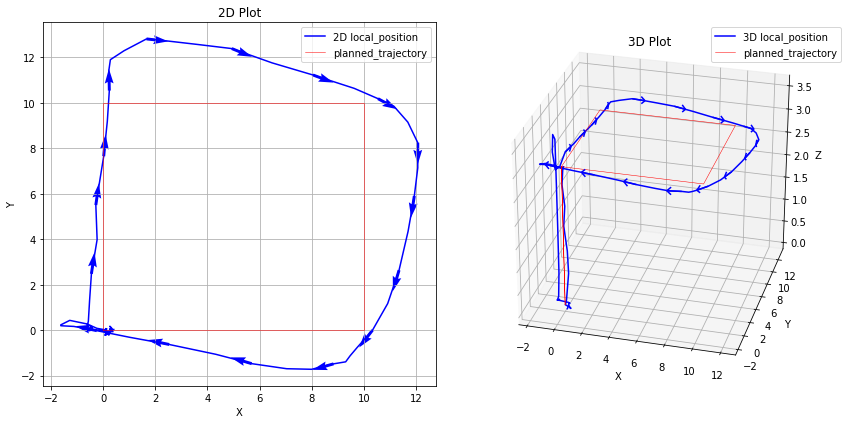

In [91]:
# Show flying path

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# Plot the drone's journey
fig = plt.figure(figsize=(12, 6))

# Create a 2D plot
ax1 = fig.add_subplot(121)
ax1.plot(local_position['x'].to_numpy(), 
         local_position['y'].to_numpy(), 
         label='2D local_position', 
         linestyle='-', color='b')
ax1.plot(planned_trajectory['x'].to_numpy(), 
         planned_trajectory['y'].to_numpy(), 
         label='planned_trajectory', 
         linestyle='-', color='r', linewidth=0.5)



ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('2D Plot')
ax1.legend()
ax1.grid(True)

# Create a 3D plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(local_position['x'].to_numpy(), 
         local_position['y'].to_numpy(), 
         local_position['z'].to_numpy(), 
         label='3D local_position', 
         linestyle='-', color='b')
ax2.plot(planned_trajectory['x'].to_numpy(), 
         planned_trajectory['y'].to_numpy(), 
         planned_trajectory['z'].to_numpy(), 
         label='planned_trajectory', 
         linestyle='-', color='r', linewidth=0.5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('3D Plot')
ax2.legend()
ax2.view_init(elev=30, azim=-75)


q_x_last = local_position['x'].iloc[0]
q_y_last = local_position['y'].iloc[0]
q_z_last = local_position['z'].iloc[0]

for i in range(round(len(local_position)) - 1):
    q_x1 = local_position['x'].iloc[i]
    q_y1 = local_position['y'].iloc[i]
    q_z1 = local_position['z'].iloc[i]
    q_x2 = local_position['x'].iloc[i+1]
    q_y2 = local_position['y'].iloc[i+1]
    q_z2 = local_position['z'].iloc[i+1]
    
    if (q_x1 - q_x_last)**2 + (q_y1 - q_y_last)**2  < 4:
        continue
    
    q_x_last = q_x1
    q_y_last = q_y1
    q_z_last = q_z1

    ax1.quiver(q_x1, q_y1, 
            q_x2 - q_x1, q_y2 - q_y1, 
            color='b')
    
    ax2.quiver(q_x1, 
            q_y1, 
            q_z1, 
            q_x2 - q_x1, 
            q_y2 - q_y1, 
            q_z2 - q_z1,
            length=1, normalize=True, color='b')


plt.tight_layout()
plt.show()
fig.savefig('drone_journey_plot.png')
